In [2]:
#!python setup.py build_ext --inplace

In [3]:
import numpy as np
import bayesflow as bf
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from simulator import DDM_EZ_retest_config as sim_v2

In [4]:
import random 
random.seed(78901212)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
def draw_prior():
    """Generates random draws from the prior."""
    v1 =np.random.uniform(low=0.0,high=5.0)
    v2 =np.random.uniform(low=-5.0,high=0.0)

    a  =np.random.uniform(low=0.6,high=3.0)
    ndt =np.random.uniform(low=0.1,high=0.7)
   # alpha =np.random.uniform(low=1.0,high=2.0)

    return np.array([v1,v2,a, ndt])

In [7]:
def prior_N(n_min=50, n_max=1000):
    """A prior fo]r the number of observation (will be called internally at each backprop step)."""
    return  np.random.randint(n_min, n_max+1, 2)

In [8]:
prior = bf.simulation.Prior(prior_fun=draw_prior,param_names=[r'$v1$',r'$v2$', r'$a$', r'$ndt$'])
var_num_obs = bf.simulation.ContextGenerator(non_batchable_context_fun=prior_N)
simulator = bf.simulation.Simulator(simulator_fun=sim_v2.simulate_diffusion_2_conds, context_generator=var_num_obs)
generative_model = bf.simulation.GenerativeModel(prior,simulator,name='EZ_retest')

INFO:root:Performing 2 pilot runs with the EZ_retest model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1185, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Shape of simulation non-batchable context: (2,)
INFO:root:No optional simulation batchable context provided.


In [9]:
prior_means, prior_stds = prior.estimate_means_and_stds()
#Prior Checking
#f = prior.plot_prior2d()

In [10]:
def configurator(sim_dict):
    """Configures the outputs of a generative model for interaction with 
    BayesFlow modules."""
    
    out = dict()
    # These will be passed through the summary network. In this case,
    # it's just the data, but it can be other stuff as well.
    data = sim_dict['sim_data'].astype(np.float32)
    
    # Extract prior draws and z-standardize with previously computed means
    params = ((sim_dict['prior_draws'].astype(np.float32)) - prior_means) / prior_stds
    #params = (params - prior_means) / prior_stds
    
    
    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(data), axis=(1, 2))
    if not np.all(idx_keep):
        print('Invalid value encountered...removing from batch')
        
    out['summary_conditions'] = data[idx_keep]
    out['parameters'] = params[idx_keep]

    
    
    
    
    # These will be concatenated to the outputs of the summary network
    # Convert N to log N since neural nets cant deal well with large numbers
    N = np.log(sim_dict['sim_non_batchable_context'])
    # Repeat N for each sim (since shared across batch), notice the
    # extra dimension needed
    N_vec = N * np.ones((data.shape[0], 1), dtype=np.float32)
    out['direct_conditions'] = N_vec
    return out


In [11]:
sim_dict= generative_model(32)

In [12]:
configurator(sim_dict)['summary_conditions'].shape

(32, 1275, 2)

In [13]:
sim_dict['sim_non_batchable_context']

array([364, 911])

In [14]:
sim_dict['sim_data'].shape[0]

32

In [15]:
sim_dict['sim_data'].shape

(32, 1275, 2)

In [16]:
N = np.log(sim_dict['sim_non_batchable_context'])
N

array([5.89715387, 6.8145429 ])

In [17]:
%%time
# Quick test
_ = configurator(generative_model(32))


CPU times: user 2.12 s, sys: 0 ns, total: 2.12 s
Wall time: 2.13 s


In [18]:
summary_net = bf.networks.InvariantNetwork(summary_dim=64,num_equiv=3)
inference_net = bf.networks.InvertibleNetwork(num_params=len(prior.param_names),num_coupling_layers=6)
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, name='v2_equive')




/tmp/ipykernel_515638/208481748.py:1: DeprecationWarning: InvariantNetwork will be deprecated. at some point. Use ``DeepSet`` instead.
  summary_net = bf.networks.InvariantNetwork(summary_dim=64,num_equiv=3)


In [19]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer, 
    generative_model=generative_model, 
    configurator=configurator,
    checkpoint_path='./checkpoints/50_1000_EZ_DDM_retest_v2_EZ_config')

INFO:root:Loaded loss history from ./checkpoints/50_1000_EZ_DDM_retest_v2_EZ_config/history_200.pkl.
INFO:root:Loaded simulation memory from ./checkpoints/50_1000_EZ_DDM_retest_v2_EZ_config/memory.pkl
INFO:root:Networks loaded from ./checkpoints/50_1000_EZ_DDM_retest_v2_EZ_config/ckpt-200
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [20]:
amortizer.summary()

Model: "v2_equive"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  614544    
 ibleNetwork)                                                    
                                                                 
 invariant_network (Invaria  multiple                  100032    
 ntNetwork)                                                      
                                                                 
Total params: 714576 (2.73 MB)
Trainable params: 714528 (2.73 MB)
Non-trainable params: 48 (192.00 Byte)
_________________________________________________________________


In [21]:
import pandas as pd
import glob
folder_path = './DATA_Lerch_Voss/Study1_LDT_RMT'
file_list = np.array(glob.glob(folder_path + "/*.dat"))
main_dataframe = pd.DataFrame(pd.read_table(file_list[0]))

In [22]:
file_list

array(['./DATA_Lerch_Voss/Study1_LDT_RMT/3024_class_words_part_1.dat',
       './DATA_Lerch_Voss/Study1_LDT_RMT/1025_class_words_part_2.dat',
       './DATA_Lerch_Voss/Study1_LDT_RMT/1011_class_pictures_part_1.dat',
       './DATA_Lerch_Voss/Study1_LDT_RMT/017_class_pictures_part_1.dat',
       './DATA_Lerch_Voss/Study1_LDT_RMT/1004_class_pictures_part_1.dat',
       './DATA_Lerch_Voss/Study1_LDT_RMT/1018_class_words_part_2.dat',
       './DATA_Lerch_Voss/Study1_LDT_RMT/1011_class_pictures_part_2.dat',
       './DATA_Lerch_Voss/Study1_LDT_RMT/2001_class_pictures_part_2.dat',
       './DATA_Lerch_Voss/Study1_LDT_RMT/1021_class_pictures_part_2.dat',
       './DATA_Lerch_Voss/Study1_LDT_RMT/015_class_words_part_2.dat',
       './DATA_Lerch_Voss/Study1_LDT_RMT/4001_class_pictures_part_1.dat',
       './DATA_Lerch_Voss/Study1_LDT_RMT/3010_class_words_part_2.dat',
       './DATA_Lerch_Voss/Study1_LDT_RMT/2005_class_words_part_1.dat',
       './DATA_Lerch_Voss/Study1_LDT_RMT/4004_class_pictur

In [23]:
#function to refine the data in accord with the Lerch_Voss_2017
def refine_data_RT(file_name):
    refined_df = pd.read_csv(file_name, sep='\s+|\s+')
    refined_df = refined_df[refined_df['RT']>200]
    refined_df = refined_df[refined_df['RT']<2500]
    refined_df['RT'] = refined_df['RT']/1000

    return refined_df

In [24]:
#Function took data and makes it compatiable with the model  


def model_compatiabel_data (df):
    # Firs change value of error respose to negative 
    df.loc[df['acc']==0, 'RT'] *= -1

    # multiply all the RTs in second condition by -1

    df.loc[df['targ_cat']==1, 'RT'] *= -1
    #Making data suitable for model
    rts = np.array(df['RT'])
    cond_arr = np.array(df['targ_cat'])
    x = np.stack((rts, cond_arr), axis=1)
    return x


    

In [25]:
i = file_list[0]

In [26]:
i

'./DATA_Lerch_Voss/Study1_LDT_RMT/3024_class_words_part_1.dat'

In [27]:
df=refine_data_RT(i)
data_rts=np.array(model_compatiabel_data(df))
df

/tmp/ipykernel_515638/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')


,nr_part,nr_block,interval_instruction,interval_block_pause,trl_block,trl_total,word,targ_cat,resp,acc,RT
0,1,1,15685,999,1,1,Verruf,1,1,1,-1.346
1,1,1,15685,999,2,2,Harfo,0,0,1,0.698
2,1,1,15685,999,3,3,Angler,1,1,1,-0.930
3,1,1,15685,999,4,4,Kaff,1,1,1,-1.234
4,1,1,15685,999,5,5,Gondel,1,1,1,-0.858
...,...,...,...,...,...,...,...,...,...,...,...
395,1,4,15685,3536,96,396,Torte,1,1,1,-0.626
396,1,4,15685,3536,97,397,Hanf,1,1,1,-0.970
397,1,4,15685,3536,98,398,Giebel,1,1,1,-0.843
398,1,4,15685,3536,99,399,Zwist,1,1,1,-0.707


In [28]:
data_rts.shape

(399, 2)

In [29]:
out={}
    
out['summary_conditions'] = data_rts.reshape( 1, data_rts.shape[0],2)
non_batch_context=np.array([data_rts[data_rts[:,1]==1].shape[0],data_rts[data_rts[:,1]==0].shape[0]])
N = np.log(non_batch_context)
N_vec = N * np.ones((1, 1), dtype=np.float32)
out['direct_conditions'] = N_vec

In [30]:
out['summary_conditions'].shape

(1, 399, 2)

In [31]:
data_rts[data_rts[:,1]==1].shape[0]

200

In [32]:
data_rts[data_rts[:,1]==0].shape[0]

199

In [33]:
non_batch_context=np.array([data_rts[data_rts[:,1]==1].shape[0],data_rts[data_rts[:,1]==0].shape[0]])

In [34]:
N = np.log(non_batch_context)

In [35]:
N

array([5.29831737, 5.29330482])

In [36]:
N_vec = N * np.ones((1, 1), dtype=np.float32)
out['direct_conditions'] = N_vec

In [37]:
out['direct_conditions']

array([[5.29831737, 5.29330482]])

In [38]:
posterior_draws = amortizer.sample(out,n_samples=1000)
post_samples = prior_means + posterior_draws * prior_stds



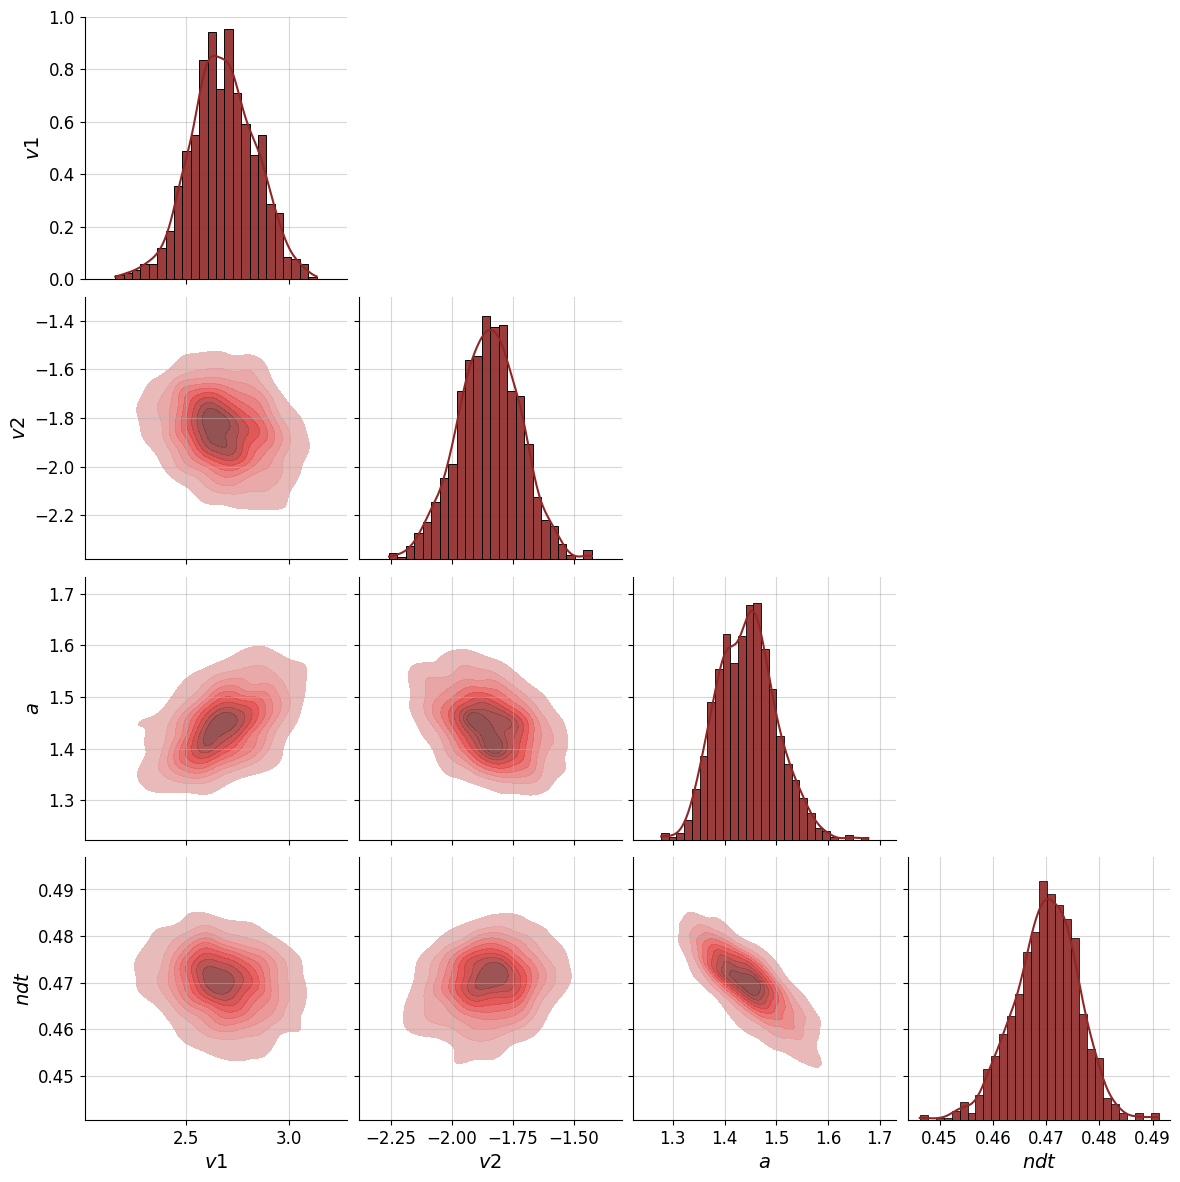

In [39]:
f = bf.diagnostics.plot_posterior_2d(post_samples,param_names=prior.param_names)

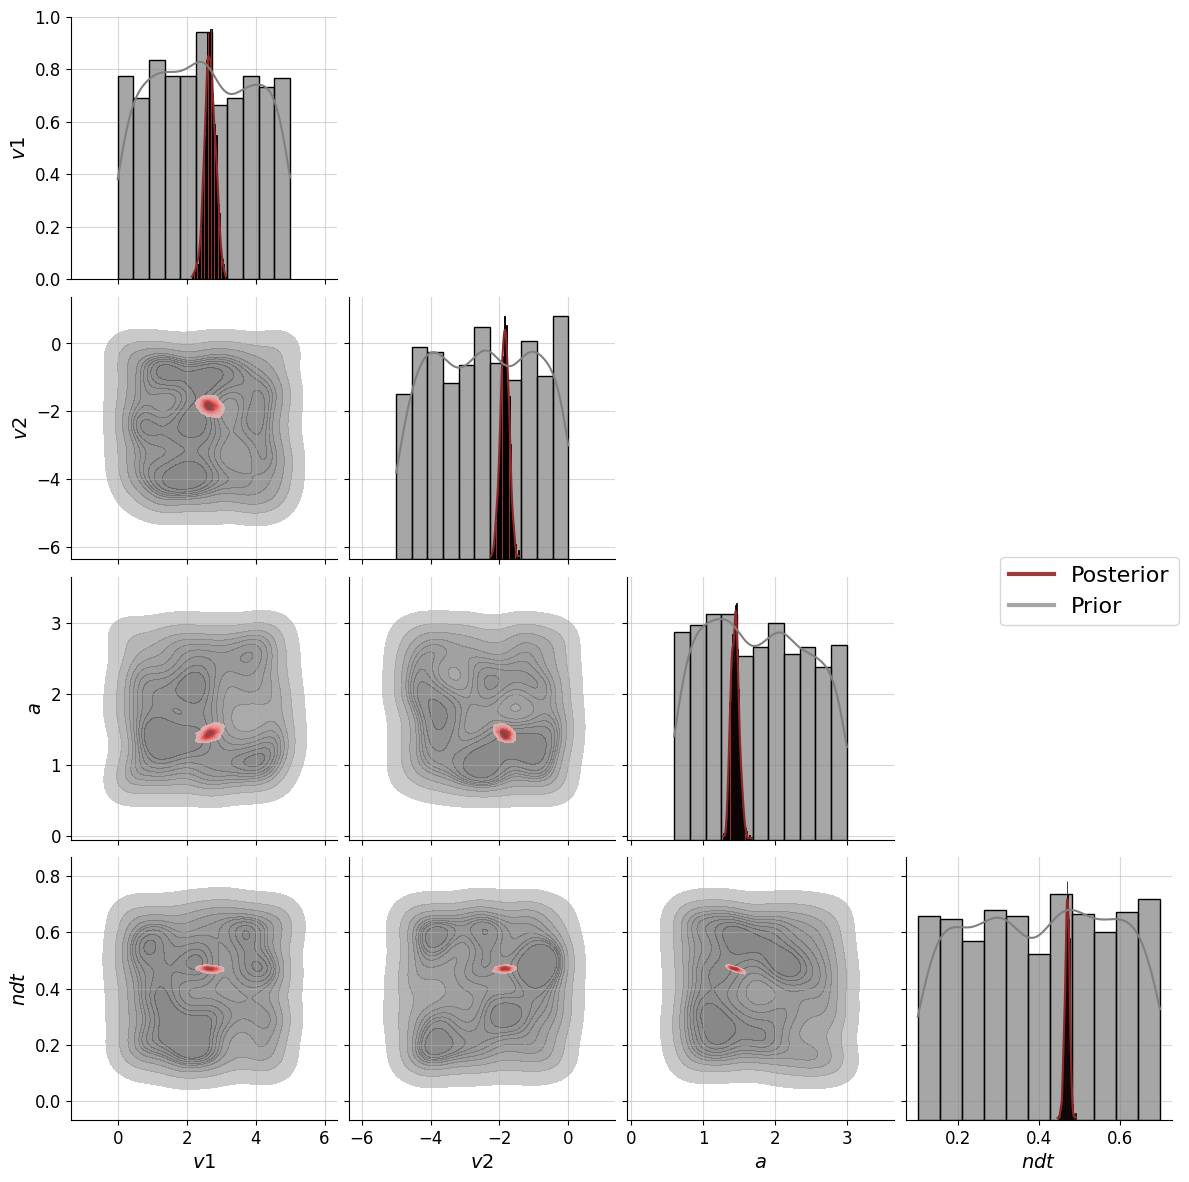

In [40]:
f = bf.diagnostics.plot_posterior_2d(post_samples, prior=prior)

In [41]:
#param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$']


In [42]:
# calculating params for all and saving them in a dataframe

param_names=[r'$v1$',r'$v2$', r'$a$', r'$ndt$']
param_data = pd.DataFrame({'Experiment':pd.Series(dtype='str'), 
                               'v1_mean':pd.Series(dtype='float'),'v2_mean':pd.Series(dtype='float'),
                               'a_mean':pd.Series(dtype='float'),'ndt_mean':pd.Series(dtype='float'),
                               'accuracy_percentage':pd.Series(dtype='float'),'mean_log_rt':pd.Series(dtype='float'),
                               'RT_mean_correct_error':pd.Series(dtype='float'),'mean_correct':pd.Series(dtype='float'),'mean_Crror':pd.Series(dtype='float'),
                                'error_array':pd.Series(dtype='float'),'RT_Cor_arr':pd.Series(dtype='float'),
                                
                            })



for i in file_list : 
    df=refine_data_RT(i)
   
    # in picture drop the first in each block
    if 'picture' in i:
        df = df.drop(df.loc[df['trl_block']==0].index)

    accuracy_percentage = df['acc'].mean()
    RT_mean_correct_error = df['RT'].mean()

    # Step 1: Filter the DataFrame to include only correct responses
    correct_responses = df[df['acc'] == 1]
    unique_points_c = correct_responses['RT'].nunique()

   

    # Check if there are enough unique points to create quartiles
   
    RT_Cor_arr = correct_responses['RT']
    
    error_responses = df[df['acc'] == 0]
    unique_points = error_responses['RT'].nunique()
    

    error_array = error_responses['RT']
    mean_correct = correct_responses['RT'].mean()
    mean_error =error_responses['RT'].mean()
    # Step 2: Apply the natural logarithm transformation
    log_transformed_rt = np.log((correct_responses['RT']*1000))
    # Step 3: Calculate the mean of these logarithmized response times
    mean_log_rt = log_transformed_rt.mean()
    
    data_rts=np.array(model_compatiabel_data(df))
    
    #considering the configurator 
    out={}
    
    out['summary_conditions'] = data_rts.reshape( 1, data_rts.shape[0],2)
    non_batch_context=np.array([data_rts[data_rts[:,1]==1].shape[0],data_rts[data_rts[:,1]==0].shape[0]])
    N = np.log(non_batch_context)
    N_vec = N * np.ones((1, 1), dtype=np.float32)
    out['direct_conditions'] = N_vec
    
    
    
    posterior_draws = amortizer.sample(out,n_samples=1000)
    post_samples = prior_means + posterior_draws * prior_stds
    
    v1_mean = post_samples[:,0].mean()
    v2_mean = post_samples[:,1].mean()
    a_mean=post_samples[:,2].mean()
    ndt_mean=post_samples[:,3].mean()
    #alpha_mean=post_samples[:,6].mean()
    
    
    

    
    #get everything after last slash
    file_name = i.rsplit('/',1)[-1]
    
    param_data.loc[len(param_data)] = [file_name, v1_mean,v2_mean,a_mean,ndt_mean,
                                       accuracy_percentage,mean_log_rt,RT_mean_correct_error,mean_correct,
                                      mean_error,error_array,RT_Cor_arr,
                                      ]
    
    
    
    
    
    
    
    
    
        
    


/tmp/ipykernel_515638/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_515638/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_515638/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

In [44]:
param_data.to_csv('./EZ_DDM_params_retest_config_RT_acc/EZ_DDM_retest_config_RT_acc.csv')

In [43]:
param_data

,Experiment,v1_mean,v2_mean,a_mean,ndt_mean,accuracy_percentage,mean_log_rt,RT_mean_correct_error,mean_correct,mean_Crror,error_array,RT_Cor_arr
0,3024_class_words_part_1.dat,2.679981,-1.840200,1.443291,0.469963,0.944862,6.604221,0.761732,0.759056,0.807591,51 0.834 61 0.611 69 0.657 71 ...,0 1.346 1 0.698 2 0.930 3 ...
1,1025_class_words_part_2.dat,3.708955,-3.252103,1.144340,0.437978,0.977500,6.359827,0.589127,0.587941,0.640667,49 0.681 65 0.552 116 0.593 218 ...,0 0.665 1 0.529 2 0.520 3 ...
2,1011_class_pictures_part_1.dat,0.989130,-2.082910,1.268319,0.574494,0.825000,6.750704,0.871310,0.869624,0.879257,4 1.210 6 1.014 22 0.736 34 ...,1 0.867 2 0.941 3 0.725 5 ...
3,017_class_pictures_part_1.dat,2.345097,-3.623016,1.711556,0.531590,0.980000,6.681648,0.819220,0.814469,1.052000,104 1.172 111 0.923 118 1.108 129 ...,1 0.721 2 0.693 3 0.724 4 ...
4,1004_class_pictures_part_1.dat,1.639430,-1.880716,1.496841,0.571646,0.924623,6.787777,0.948915,0.911571,1.407000,42 0.818 45 0.918 55 1.239 62 ...,1 0.852 2 0.763 3 0.631 4 ...
...,...,...,...,...,...,...,...,...,...,...,...,...
409,2005_class_pictures_part_1.dat,2.156499,-2.199379,1.550323,0.592882,0.964646,6.802522,0.932389,0.928921,1.027000,31 0.746 65 0.994 81 1.399 84 ...,1 0.684 2 0.676 3 0.678 4 ...
410,1023_class_pictures_part_1.dat,3.175399,-3.520718,1.782863,0.546278,0.990000,6.682415,0.806460,0.807955,0.658500,"69 0.667 166 0.650 Name: RT, dtype: flo...",1 0.756 2 0.789 3 0.702 4 ...
411,4012_class_pictures_part_1.dat,2.034562,-1.965645,1.420212,0.484229,0.939394,6.644244,0.803212,0.798495,0.876333,16 0.748 38 1.059 50 0.849 65 ...,1 0.794 2 1.115 3 0.725 4 ...
412,4012_class_pictures_part_2.dat,2.120683,-2.622362,1.273321,0.446783,0.935000,6.498061,0.678015,0.677139,0.690615,28 0.852 43 0.642 64 0.709 108 ...,1 1.264 2 0.690 3 0.513 4 ...


In [40]:
# calculating params for all and saving them in a dataframe

param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$']
param_data = pd.DataFrame({'Experiment':pd.Series(dtype='str'), 
                               'v1_mean':pd.Series(dtype='float'),'v2_mean':pd.Series(dtype='float'),'zr_mean':pd.Series(dtype='float'),
                               'a_mean':pd.Series(dtype='float'),'ndt_mean':pd.Series(dtype='float'), 'sndt_mean':pd.Series(dtype='float'),
                               'alpha_mean':pd.Series(dtype='float'),
                               'accuracy_percentage':pd.Series(dtype='float'),'mean_log_rt':pd.Series(dtype='float'),
                               'RT_mean_correct_error':pd.Series(dtype='float'),'mean_correct':pd.Series(dtype='float'),'mean_Crror':pd.Series(dtype='float'),
                                'error_array':pd.Series(dtype='float'),'RT_Cor_arr':pd.Series(dtype='float'),
                                'q1_C':pd.Series(dtype='float'),'q2_C':pd.Series(dtype='float'),'q3_C':pd.Series(dtype='float'),'q4_C':pd.Series(dtype='float'),
                                'q1_E':pd.Series(dtype='float'),'q2_E':pd.Series(dtype='float'),'q3_E':pd.Series(dtype='float'),'q4_E':pd.Series(dtype='float'),

                            })



for i in file_list : 
    df=refine_data_RT(i)
    








        
    # in picture drop the first in each block
    if 'picture' in i:
        df = df.drop(df.loc[df['trl_block']==0].index)

    accuracy_percentage = df['acc'].mean()
    RT_mean_correct_error = df['RT'].mean()

    # Step 1: Filter the DataFrame to include only correct responses
    correct_responses = df[df['acc'] == 1]
    unique_points_c = correct_responses['RT'].nunique()

    if unique_points_c >= 4:
        correct_responses['RT_quartile_C'] = pd.qcut(correct_responses['RT'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
        q1_C = np.array(correct_responses[correct_responses['RT_quartile_C']=='Q1']['RT'])
        q2_C = np.array(correct_responses[correct_responses['RT_quartile_C']=='Q2']['RT'])
        q3_C = np.array(correct_responses[correct_responses['RT_quartile_C']=='Q3']['RT'])
        q4_C = np.array(correct_responses[correct_responses['RT_quartile_C']=='Q4']['RT'])


    else:
        correct_responses['RT_quartile_C'] = np.nan  # Assign NaN when not enough unique data points
        q1_C = np.nan
        q2_C = np.nan
        q3_C = np.nan
        q4_C = np.nan

    # Check if there are enough unique points to create quartiles
   
    RT_Cor_arr = correct_responses['RT']
    
    error_responses = df[df['acc'] == 0]
    unique_points = error_responses['RT'].nunique()
    if unique_points >= 4:
        error_responses['RT_quartile_E'] = pd.qcut(error_responses['RT'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
        q1_E = np.array(error_responses[error_responses['RT_quartile_E']=='Q1']['RT'])
        q2_E = np.array(error_responses[error_responses['RT_quartile_E']=='Q2']['RT'])
        q3_E = np.array(error_responses[error_responses['RT_quartile_E']=='Q3']['RT'])
        q4_E = np.array(error_responses[error_responses['RT_quartile_E']=='Q4']['RT'])


    else:
        error_responses['RT_quartile_E'] = np.nan  # Assign NaN when not enough unique data points
        q1_E = np.nan
        q2_E = np.nan
        q3_E = np.nan
        q4_E = np.nan


    error_array = error_responses['RT']
    mean_correct = correct_responses['RT'].mean()
    mean_error =error_responses['RT'].mean()
    # Step 2: Apply the natural logarithm transformation
    log_transformed_rt = np.log((correct_responses['RT']*1000))
    # Step 3: Calculate the mean of these logarithmized response times
    mean_log_rt = log_transformed_rt.mean()
    
    data_rts=np.array(model_compatiabel_data(df))
    
    #considering the configurator 
    out={}
    
    out['summary_conditions'] = data_rts.reshape( 1, data_rts.shape[0],2)
    non_batch_context=np.array([data_rts[data_rts[:,1]==1].shape[0],data_rts[data_rts[:,1]==0].shape[0]])
    N = np.log(non_batch_context)
    N_vec = N * np.ones((1, 1), dtype=np.float32)
    out['direct_conditions'] = N_vec
    
    
    
    posterior_draws = amortizer.sample(out,n_samples=1000)
    post_samples = prior_means + posterior_draws * prior_stds
    
    v1_mean = post_samples[:,0].mean()
    v2_mean = post_samples[:,1].mean()
    zr_mean = post_samples[:,2].mean()
    a_mean=post_samples[:,3].mean()
    ndt_mean=post_samples[:,4].mean()
    sndt_mean= post_samples[:,5].mean()
    alpha_mean=post_samples[:,6].mean()
    
    
    

    
    #get everything after last slash
    file_name = i.rsplit('/',1)[-1]
    
    param_data.loc[len(param_data)] = [file_name, v1_mean,v2_mean,zr_mean,a_mean,ndt_mean,sndt_mean,alpha_mean,
                                       accuracy_percentage,mean_log_rt,RT_mean_correct_error,mean_correct,
                                      mean_error,error_array,RT_Cor_arr,
                                      q1_C,q2_C,q3_C,q4_C,
                                      q1_E,q2_E,q3_E,q4_E,]
    
    
    
    
    
    
    
    
    
        
    


/tmp/ipykernel_432900/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_432900/304414503.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_responses['RT_quartile_C'] = pd.qcut(correct_responses['RT'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
/tmp/ipykernel_432900/304414503.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [41]:
#param_data.to_csv('./params_retest_config_RT_acc/retest_config_RT_acc_quartiles.csv')

In [30]:
param_data

,Experiment,v1_mean,v2_mean,zr_mean,a_mean,ndt_mean,sndt_mean,alpha_mean,accuracy_percentage,mean_log_rt,...,error_array,RT_Cor_arr,q1_C,q2_C,q3_C,q4_C,q1_E,q2_E,q3_E,q4_E
0,3024_class_words_part_1.dat,2.663851,-1.991315,0.521433,1.258426,0.491625,0.020603,1.913480,0.944862,6.604221,...,51 0.834 61 0.611 69 0.657 71 ...,0 1.346 1 0.698 2 0.930 3 ...,"[0.611, 0.619, 0.56, 0.601, 0.53, 0.617, 0.571...","[0.698, 0.658, 0.634, 0.635, 0.642, 0.682, 0.6...","[0.802, 0.771, 0.722, 0.794, 0.754, 0.779, 0.7...","[1.346, 0.93, 1.234, 0.858, 0.859, 0.866, 0.85...","[0.611, 0.657, 0.585, 0.57, 0.643, 0.571]","[0.698, 0.667, 0.738, 0.738, 0.706, 0.698]","[0.834, 0.891, 0.834, 0.881]","[0.922, 0.986, 1.091, 1.067, 1.146, 1.233]"
1,1025_class_words_part_2.dat,3.999124,-3.259681,0.485222,0.983901,0.445056,0.008689,1.855533,0.977500,6.359827,...,49 0.681 65 0.552 116 0.593 218 ...,0 0.665 1 0.529 2 0.520 3 ...,"[0.52, 0.506, 0.513, 0.52, 0.481, 0.521, 0.497...","[0.529, 0.553, 0.546, 0.546, 0.538, 0.545, 0.5...","[0.594, 0.569, 0.585, 0.569, 0.562, 0.577, 0.5...","[0.665, 0.706, 0.617, 0.664, 0.961, 0.625, 0.6...","[0.552, 0.546, 0.498]","[0.593, 0.574]","[0.681, 0.616]","[0.994, 0.712]"
2,1011_class_pictures_part_1.dat,1.066390,-2.230228,0.466307,0.806738,0.675546,0.072969,1.695320,0.825000,6.750704,...,4 1.210 6 1.014 22 0.736 34 ...,1 0.867 2 0.941 3 0.725 5 ...,"[0.725, 0.719, 0.639, 0.703, 0.729, 0.744, 0.6...","[0.806, 0.832, 0.83, 0.768, 0.765, 0.81, 0.759...","[0.867, 0.941, 0.947, 0.922, 0.941, 0.872, 0.9...","[0.953, 0.961, 1.081, 1.034, 1.184, 1.641, 1.0...","[0.736, 0.735, 0.705, 0.721, 0.677, 0.61, 0.71...","[0.745, 0.761, 0.827, 0.744, 0.83, 0.788, 0.81...","[0.982, 0.947, 0.968, 0.879, 0.922, 0.912, 0.8...","[1.21, 1.014, 1.002, 1.035, 1.204, 1.024, 0.98..."
3,017_class_pictures_part_1.dat,2.126211,-4.138882,0.556746,1.451695,0.568181,0.022242,1.828227,0.980000,6.681648,...,104 1.172 111 0.923 118 1.108 129 ...,1 0.721 2 0.693 3 0.724 4 ...,"[0.693, 0.686, 0.67, 0.608, 0.693, 0.666, 0.69...","[0.721, 0.724, 0.753, 0.757, 0.709, 0.731, 0.7...","[0.86, 0.793, 0.783, 0.777, 0.8, 0.861, 0.815,...","[0.899, 0.973, 1.165, 1.03, 1.141, 0.92, 0.878...",[0.923],[1.005],[1.108],[1.172]
4,1004_class_pictures_part_1.dat,1.648524,-1.901891,0.492808,1.361342,0.592857,0.027327,1.901476,0.924623,6.787777,...,42 0.818 45 0.918 55 1.239 62 ...,1 0.852 2 0.763 3 0.631 4 ...,"[0.631, 0.75, 0.747, 0.721, 0.749, 0.679, 0.67...","[0.852, 0.763, 0.777, 0.801, 0.795, 0.789, 0.7...","[0.886, 0.927, 0.919, 0.949, 0.892, 0.894, 0.8...","[1.892, 1.057, 1.335, 0.984, 1.054, 1.038, 1.0...","[0.818, 0.918, 0.791, 0.92]","[1.239, 1.09, 1.118, 1.224]","[1.279, 1.295, 1.584]","[2.391, 1.77, 2.223, 2.445]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,2005_class_pictures_part_1.dat,2.270942,-2.194582,0.469566,1.406032,0.617111,0.010736,1.903231,0.964646,6.802522,...,31 0.746 65 0.994 81 1.399 84 ...,1 0.684 2 0.676 3 0.678 4 ...,"[0.684, 0.676, 0.678, 0.643, 0.757, 0.719, 0.7...","[0.815, 0.812, 0.791, 0.781, 0.777, 0.816, 0.7...","[0.839, 0.922, 0.912, 0.944, 0.964, 0.922, 0.9...","[2.193, 1.032, 1.059, 1.114, 1.009, 1.191, 1.0...","[0.746, 0.796]","[0.931, 0.937]",[0.994],"[1.399, 1.386]"
410,1023_class_pictures_part_1.dat,3.562628,-3.617683,0.474257,1.569220,0.579716,0.015377,1.793197,0.990000,6.682415,...,"69 0.667 166 0.650 Name: RT, dtype: flo...",1 0.756 2 0.789 3 0.702 4 ...,"[0.702, 0.701, 0.678, 0.703, 0.681, 0.715, 0.6...","[0.756, 0.772, 0.725, 0.731, 0.722, 0.771, 0.7...","[0.789, 0.785, 0.778, 0.85, 0.84, 0.779, 0.815...","[0.902, 0.944, 0.906, 0.907, 1.058, 0.9, 0.964...",NaN,NaN,NaN,NaN
411,4012_class_pictures_part_1.dat,2.170928,-1.989389,0.460668,1.267405,0.505675,0.015274,1.871496,0.939394,6.644244,...,16 0.748 38 1.059 50 0.849 65 ...,1 0.794 2 1.115 3 0.725 4 ...,"[0.58, 0.548, 0.554, 0.506, 0.568, 0.583, 0.57...","[0.686, 0.704, 0.688, 0.681, 0.684, 0.709, 0.6...","[0.794, 0.725, 0.73, 0.818, 0.74

In [62]:
df_word_part_1 = df[df['Experiment'].str.contains('class_words_part_1.')]
df_word_part_2 = df[df['Experiment'].str.contains('class_words_part_2.')]
df_word_part_2

,Experiment,rt_mean,acc_rate
1,1025_class_words_part_2.dat,0.589127,0.977500
5,1018_class_words_part_2.dat,0.565233,0.977500
9,015_class_words_part_2.dat,0.660065,0.935000
11,3010_class_words_part_2.dat,0.740875,0.947500
16,4003_class_words_part_2.dat,0.738160,0.977444
...,...,...,...
389,4008_class_words_part_2.dat,0.682716,0.935135
392,011_class_words_part_2.dat,0.552938,0.965000
398,1001_class_words_part_2.dat,0.627193,0.952500
403,019_class_words_part_2.dat,0.705590,0.923077


In [63]:
df_word_part_1=df_word_part_1.sort_values('Experiment')
df_word_part_2=df_word_part_2.sort_values('Experiment')

In [64]:
import pandas as pd
import scipy.linalg as sp
import numpy as np
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [65]:
from scipy.stats import pearsonr
from scipy.stats import chi2
chi2.ppf((1-0.001), df=2)
#> 9.21


13.815510557964274

In [ ]:
params_mean=['rt_mean','acc_rate']
#corr_frame['Experiment']=df_word_part_1['Experiment']
final_corr_frame = pd.DataFrame()
final_corr_frame['Experiment']=['class_words']
final_corr_frame['corr_type']=['between session']

final_corr_dict = {}
from scipy.stats import chi2
chi2.ppf((1-0.001), df=2)

for param in params_mean:
    corr_frame = pd.DataFrame()
    par_1='param_1_'+str(param)
    par_2='param_2_'+str(param)
    data_analysis = {'Experiment':df_word_part_1['Experiment'],par_1:np.array(df_word_part_1[param]),par_2:np.array(df_word_part_2[param])}
    corr_frame = pd.DataFrame(data_analysis)    
    df_x = corr_frame[[par_1, par_2]]
    df_x['mahala'] = mahalanobis(x=df_x, data=corr_frame[[par_1, par_2]])
    df_x['p_value'] = 1 - chi2.cdf(df_x['mahala'], 2)

# Extreme values with a significance level of 0.01
    df_outliers=df_x.loc[df_x.p_value < 0.001]
    ind=df_outliers.index
#drop the outliers with index     
    corr_without_outlier = corr_frame.drop(ind)
    x = corr_without_outlier[par_1]
    y = corr_without_outlier[par_2]
    corr =  np.corrcoef(x, y)[0,1]
    print(param)
    plt.plot(x, y, '.', color='black')
    plt.show()
    
    final_corr_frame['corr_'+str(param)] = [corr]

#saving the results 

final_corr_frame.to_csv('corr_between_session_word_class.csv',index=False)
 
    


In [24]:
#num_val = 300
#val_sims = generative_model(num_val)
#val_sims

In [25]:
#h = trainer.train_online(epochs=5, iterations_per_epoch=1000, batch_size=128, validation_sims=val_sims)

In [26]:
#f = bf.diagnostics.plot_losses(h['train_losses'], h['val_losses'])

# Validation Phase
## Inspecting the Latent Space

In [27]:
#f = trainer.diagnose_latent2d()

# Simulation-Based Calibration - Rank Histograms

In [86]:
def prior_N(n_min=100, n_max=100):
    """A prior fo]r the number of observation (will be called internally at each backprop step)."""
    return  np.random.randint(n_min, n_max+1, 2)

In [142]:
num_test = 1000
num_posterior_draws_recovery = 5000
new_sims = configurator(generative_model(num_test))

In [143]:
new_sims['summary_conditions'].shape


(1000, 1000, 2)

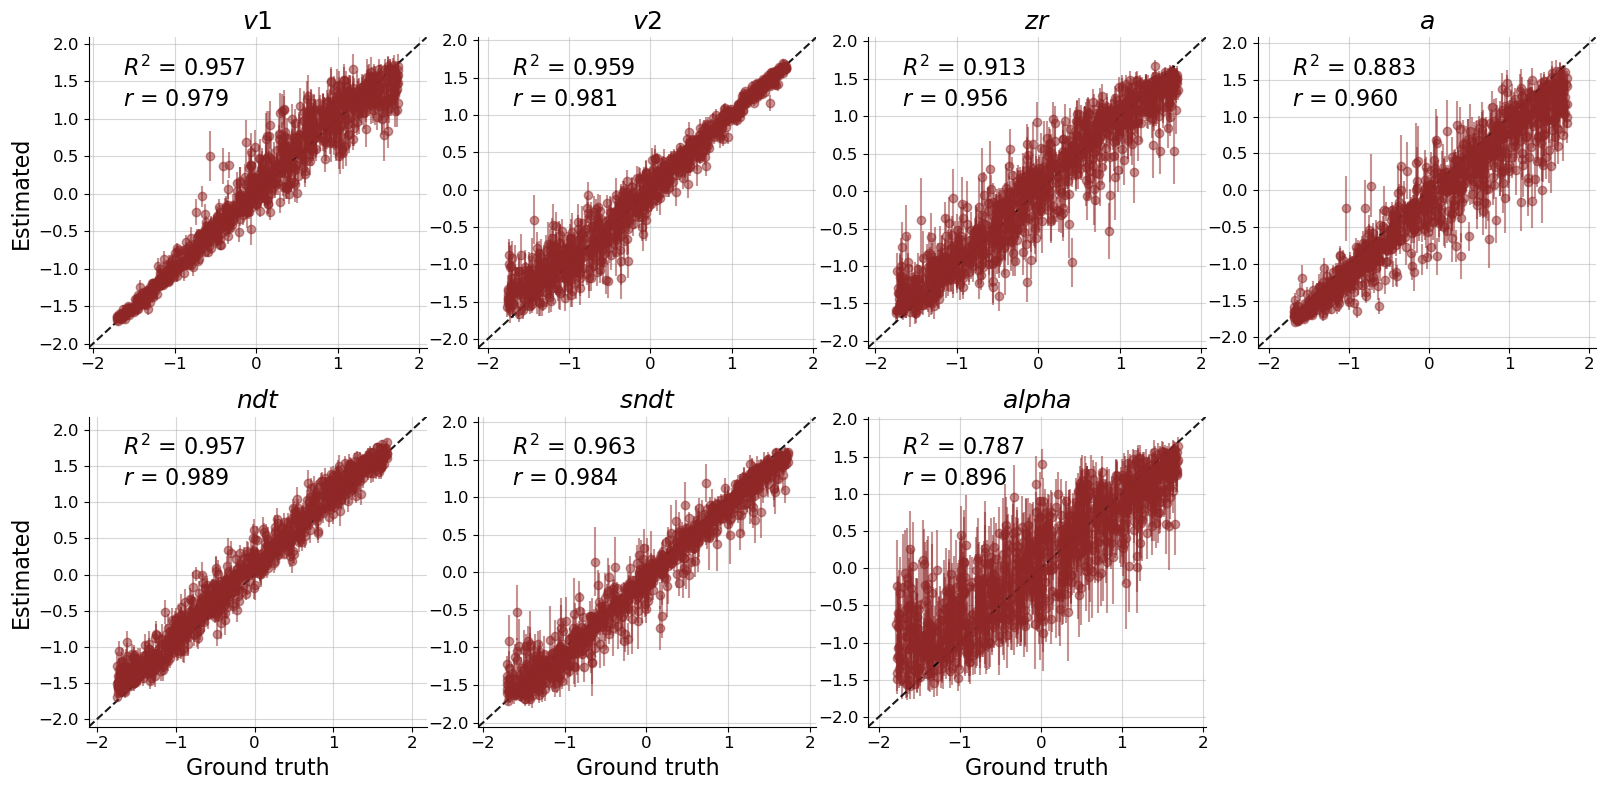

In [144]:
posterior_draws = amortizer.sample(new_sims, n_samples=num_posterior_draws_recovery)
fig = bf.diagnostics.plot_recovery(posterior_draws, new_sims['parameters'],param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])

IndexError: unsupported iterator index

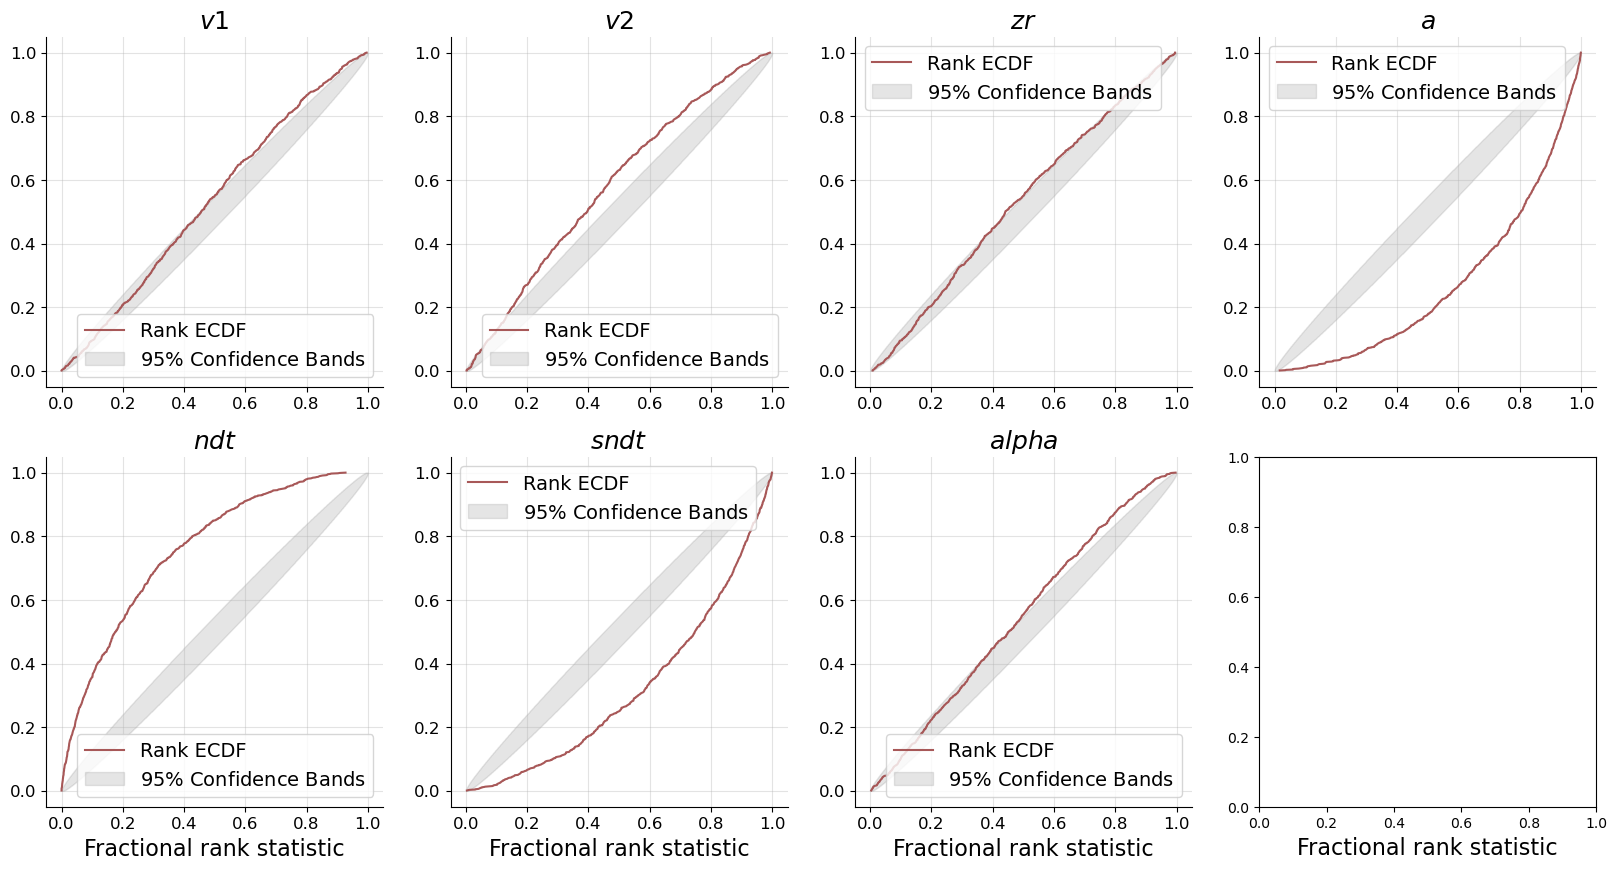

In [145]:
#posterior_draws = amortizer.sample(new_sims, n_samples=100)
f = bf.diagnostics.plot_sbc_ecdf(posterior_draws, new_sims['parameters'],param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])

In [ ]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_draws, new_sims['parameters'], stacked=True, 
                       difference=True, legend_fontsize=12, fig_size=(10, 8))

In [ ]:
posterior_draws = amortizer.sample(new_sims, n_samples=50)
f = bf.diagnostics.plot_sbc_histograms(posterior_draws, new_sims['parameters'], num_bins=10,param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])

ValueError: cannot reshape array of size 50000 into shape (1000,5000,1)

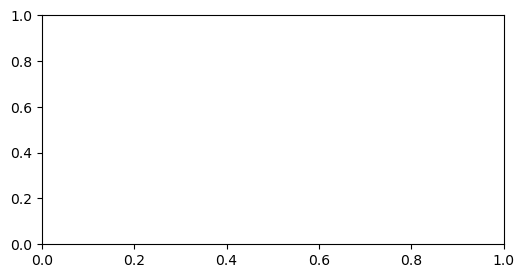

In [52]:
#posterior_draws = amortizer.sample(new_sims, n_samples=num_posterior_draws_recovery)
# Michael Nunez's recovery function
def recovery(possamps, truevals):  # Parameter recovery plots
    """Plots true parameters versus 99% and 95% credible intervals of recovered
    parameters. Also plotted are the median (circles) and mean (stars) of the posterior
    distributions.

    Parameters
    ----------
    possamps : ndarray of posterior chains where the last dimension is the
    number of chains, the second to last dimension is the number of samples in
    each chain, all other dimensions must match the dimensions of truevals

    truevals : ndarray of true parameter values
    """

    # Number of chains
    nchains = possamps.shape[-1]

    # Number of samples per chain
    nsamps = possamps.shape[-2]

    # Number of variables to plot
    nvars = np.prod(possamps.shape[0:-2])

    # Reshape data
    alldata = np.reshape(possamps, (nvars, nchains, nsamps))
    alldata = np.reshape(alldata, (nvars, nchains * nsamps))
    truevals = np.reshape(truevals, (nvars))

    # Plot properties
    LineWidths = np.array([2, 5])
    teal = np.array([0, .7, .7])
    blue = np.array([0, 0, 1])
    orange = np.array([1, .3, 0])
    Colors = [teal, blue]

    for v in range(0, nvars):
        # Compute percentiles
        bounds = stats.scoreatpercentile(alldata[v, :], (.5, 2.5, 97.5, 99.5))
        for b in range(0, 2):
            # Plot credible intervals
            credint = np.ones(100) * truevals[v]
            y = np.linspace(bounds[b], bounds[-1 - b], 100)
            lines = plt.plot(credint, y)
            plt.setp(lines, color=Colors[b], linewidth=LineWidths[b])
            if b == 1:
                # Mark median
                mmedian = plt.plot(truevals[v], np.median(alldata[v, :]), 'o')
                plt.setp(mmedian, markersize=10, color=[0., 0., 0.])
                # Mark mean
                mmean = plt.plot(truevals[v], np.mean(alldata[v, :]), '*')
                plt.setp(mmean, markersize=10, color=teal)
    # Plot line y = x
    tempx = np.linspace(np.min(truevals), np.max(
        truevals), num=100)
    recoverline = plt.plot(tempx, tempx)
    plt.setp(recoverline, linewidth=3, color=orange)


# Plot the results
fig=plt.figure(figsize=(15,8), tight_layout=True)

columns = 3
rows = 3
param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$']
for i in range(len(param_names)):
    
    fig.add_subplot(rows, columns, i+1)
    recovery(posterior_draws[:, :, i].reshape(num_test, num_posterior_draws_recovery, 1), new_sims['parameters'][:, i].squeeze())
    plt.xlabel('Grand truth', fontsize=16)
    plt.ylabel('Posterior', fontsize=16)
    plt.title(param_names[i], fontsize=16)
    if i==0:
        plt.legend(['99% CI','95% CI','Median', 'Mean'], fontsize=11, loc = 'upper left')




In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import r2_score
param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$']
def compute_performance_metrics(model, n_points_grid, param_names, 
                                 n_sim=20, n_test=300, n_samples=2000, transform=None):
    """
    Compute metrics for different numbers of datapoints.
    ---------

    Arguments:
    model           : tf.keras.Model -- the invertible chaoin with an optional summary net
                                        both models are jointly trained
    param_names     : list of strings -- the names of the parameters
    simulate_fun    : callable -- the simulate function
    n_test          : number of test datasets
    n_samples       : number of samples from the approximate posterior
    transform       : callable ot None -- a function to transform X and theta, if given
    ----------

    Returns:
    metrics : dict -- a dictionary with the metrics
    """

    metrics = {
        'rmse':  {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names},
        'nrmse': {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names},
        'r2':    {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names},
        'std':   {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names}
    }
    
    with tqdm(total=n_points_grid.shape[0]) as p_bar:
        for n, n_points in enumerate(n_points_grid):
            def prior_N(n_min=n_points, n_max=n_points):
                return np.random.randint(n_min, n_max+1)
            p_bar.set_postfix_str("Simulating with N={}".format(n_points))
            for si in range(n_sim):
                
                # Simulate data 
                prior = bf.simulation.Prior(prior_fun=draw_prior,param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])
                var_num_obs = bf.simulation.ContextGenerator(non_batchable_context_fun=prior_N)
                simulator = bf.simulation.Simulator(simulator_fun=sim_v2.simulate_diffusion_2_conds, context_generator=var_num_obs)
                generative_model = bf.simulation.GenerativeModel(prior,simulator,name='v2_equiv')
                
                x = configurator(generative_model(n_test))
                theta_test_s , X_test_s = x['parameters'] , x['summary_conditions']
                
               # X_test_s, theta_test_s = simulate_fun(n_test, n_points=n_points)
               # if transform is not None:
               #     X_test_s, theta_test_s = transform(X_test_s, theta_test_s)
               # theta_test_s = theta_test_s.numpy()

                # Sample from posterior and compute mean and variance
                posterior_draws = model.sample(x, n_samples=n_samples)
                theta_test_hat = posterior_draws.mean(1)
                theta_test_std = posterior_draws.std(axis=1, ddof=1)

                
                #theta_samples = model.sample(X_test_s, n_samples=n_samples, to_numpy=True)
                #theta_test_hat = theta_samples.mean(0)
                #theta_test_std = theta_samples.std(axis=0, ddof=1)

                # --- Plot true vs estimated posterior means on a single row --- #
                for k, name in enumerate(param_names):

                    # Compute NRMSE
                    rmse = np.sqrt(np.mean( (theta_test_hat[:, k] - theta_test_s[:, k])**2 ))
                    nrmse = rmse / (theta_test_s[:, k].max() - theta_test_s[:, k].min())

                    # Compute R2
                    r2 = r2_score(theta_test_s[:, k], theta_test_hat[:, k])

                    # Extract mean posterior std
                    std = np.mean(theta_test_std[:, k])

                    # Add to dict
                    metrics['rmse'][name][n, si] = rmse
                    metrics['nrmse'][name][n, si] = nrmse
                    metrics['r2'][name][n, si] = r2
                    metrics['std'][name][n, si]  = std
            p_bar.update(1)
        return metrics


In [ ]:
n_points_grid=np.arange(100, 1001, 10)

metrics = compute_performance_metrics(amortizer, 
                    n_points_grid, 
                    param_names=param_names, 
                    #simulate_fun=data_generator,
                    n_sim=10, 
                    n_test=300, 
                    n_samples=2000)
                    #transform=transform)

In [ ]:
def plot_performance_metrics(metrics, n_points_grid, param_names, figsize=(12, 4), show=True, 
                             xlabel=r'$n$', filename=None, legend_loc=None, std_ci=2, font_size=12):
    
    """Plots specified metrics over ns."""

    # Plot settings
    plt.rcParams['font.size'] = font_size

    # Initialize figure
    f, axarr = plt.subplots(1, 2, figsize=figsize)

    for i, metric in enumerate(['nrmse', 'r2']):
        for p in param_names:

            metric_mean = metrics[metric][p].mean(axis=1)
            metric_std = metrics[metric][p].std(axis=1, ddof=1)

            axarr[i].plot(n_points_grid, metric_mean, label=p, lw=2)
            axarr[i].fill_between(n_points_grid, 
                            metric_mean-std_ci*metric_std, 
                            metric_mean+std_ci*metric_std, 
                            interpolate=True, alpha=0.2)

        if metric == 'nrmse':
            axarr[i].set_ylabel('NRMSE')
        elif metric == 'r2':
            axarr[i].set_ylabel(r'$R^{2}$')
        axarr[i].set_xlabel(xlabel)

        axarr[i].spines['right'].set_visible(False)
        axarr[i].spines['top'].set_visible(False)
        if legend_loc is not None:
            axarr[i].legend(loc=legend_loc[i], fontsize=10)
        else:
            axarr[i].legend(fontsize=12)

    f.tight_layout()
    
    if show:
        plt.show()
    
    if filename is not None:
        f.savefig("figures/{}_metrics.png".format(filename), dpi=600, bbox_inches='tight')



In [ ]:
plot_performance_metrics(metrics, 
                         n_points_grid, 
                         param_names, 
                         legend_loc=['upper right', 'lower right'],
                         xlabel=r'Number of trials ($N$)', 
                         figsize=(12, 6),
                         filename='Levy_Metrics')

In [ ]:
x = configurator(generative_model(32))
theta_test_s , X_test_s = x['parameters'] , x['summary_conditions']

In [ ]:
X_test_s.shape

In [ ]:
n_samples  = 1000
posterior_draws = amortizer.sample(x, n_samples=num_posterior_draws_recovery)
#theta_samples = amortizer.sample(X_test_s, n_samples=n_samples)

In [ ]:
posterior_draws.shape

In [ ]:
theta_test_hat = posterior_draws.mean(1)
theta_test_std = posterior_draws.std(axis=1, ddof=1)


In [ ]:
theta_test_hat.shape

In [ ]:
theta_test_hat

In [ ]:
theta_test_std.shape

In [ ]:
theta_test_std

In [ ]:
r2 = r2_score(theta_test_s[:,1], theta_test_hat[:,1])

In [ ]:
r2 = r2_score(theta_test_s[:,2], theta_test_hat[:,2])
r2

In [ ]:
r2

In [ ]:
r2 = r2_score(theta_test_s[:, k], theta_test_hat[:, k])

In [ ]:
theta_test_s.shape

In [ ]:
n_points_grid=np.arange(100, 121, 10)
for n, n_points in enumerate(n_points_grid):
    print (n_points)

In [ ]:
n_points_grid=np.arange(100, 121, 10)
metrics = compute_performance_metrics(amortizer, 
                    n_points_grid, 
                    param_names=param_names, 
                    simulate_fun=data_generator,
                    n_sim=10, 
                    n_test=300, 
                    n_samples=2000
                    )

In [ ]:
f = bf.diagnostics.plot_posterior_2d(single_pp,param_names=prior.param_names)

In [ ]:
f = bf.diagnostics.plot_posterior_2d(single_pp, prior=prior)

In [ ]:
import matplotlib.pyplot as plt

def plot_ppc(config, post_samples, logscale=True, color='Blue', 
                            dummy=True, figsize=(12, 6), font_size=18):
    """
    Helper function to perform some plotting of the posterior predictive.
    """
    # Plot settings
    plt.rcParams['font.size'] = font_size
    
    # Remove parameters < 0
    samples = post_samples[np.sum(post_samples < 0, axis=1) == 0]
    
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Re-simulations
    sims = []
    for i in range(samples.shape[0]):  
        # Note - simulator returns 2D arrays of shape (T, 1), so we remove trailing dim 
        sim_cases = stationary_SIR(samples[i], config['N'], config['T'])[:, 0]
        sims.append(sim_cases)
    sims = np.array(sims)
    
    # Compute quantiles for each t = 1,...,T
    qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
    qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
    qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)
    
    # Plot median predictions and observed data
    ax.plot(np.median(sims, axis=0), label='Median predicted cases', color=color)
    ax.plot(config['obs_data'], marker='o', label='Reported cases', color='black', linestyle='dashed', alpha=0.8)
    
    # Add compatibility intervals (also called credible intervals)
    ax.fill_between(range(config['T']), qs_50[0], qs_50[1], color=color, alpha=0.3, label='50% CI')
    ax.fill_between(range(config['T']), qs_90[0], qs_90[1], color=color, alpha=0.2, label='90% CI')
    ax.fill_between(range(config['T']), qs_95[0], qs_95[1], color=color, alpha=0.1, label='95% CI')
    
    # Grid and schmuck
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Days since pandemic onset')
    ax.set_ylabel('Number of cases')
    ax.minorticks_off()
    if logscale:
        ax.set_yscale('log')
    ax.legend(fontsize=font_size)
    return f

In [ ]:
f = plot_ppc(config, post_samples)
